# Note to Viewers:

The majority of this code was borrowed from an existing colab notebook online. Here are the main changes I made to it:
- Adding special tokens for each meditation type to the tokenizer and training my model using those along with a tokenized dataset
- Pushing to Hugging Face Repo instead of saving the directory in my drive

Here's the link to the [original colab notebook](https://colab.research.google.com/drive/13dZVYEOMhXhkXWfvSMVM1TTtUDrT6Aeh?usp=sharing#scrollTo=NKGBoVwuhM4H).
I found it at the following [Reddit thread](https://www.reddit.com/r/MLQuestions/comments/y14x8r/how_can_i_finetune_gpt2_for_movie_script/)

# GPT-2 Fine-Tuning Tutorial with PyTorch & Huggingface in Colab




# Setup

In [ ]:
!pip install transformers

In [18]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
# % matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel, pipeline
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
%matplotlib inline

In [ ]:
!nvidia-smi

# Create Training Set

The data used to finetune the language model is a set of around 1000 DJ biographies, with the aim of generating them in the same general format and style.

This data isn't public so if you want to use this script, you'll have to source your own training set.

In [ ]:
# mount my Google Drive directory and access the training data located there
# gdrive_dir = '/content/gdrive/'

filename = 'tokenized-dataset.csv'

# drive.mount(gdrive_dir, force_remount=True)


In [ ]:
# copy the data to the current Colab working directory
# !cp $data_dir/$filename .

In [ ]:
# load into a data frame
df = pd.read_csv(filename)
# df.dropna(inplace=True) #  remove NA values
print(df)

     Meditation_Type                                                URL  \
0          body-scan                                                NaN   
1          body-scan                                                NaN   
2          body-scan                                                NaN   
3           movement                                                NaN   
4           movement                                                NaN   
...              ...                                                ...   
4716        movement  https://www.youtube.com/watch?v=4t45O953P80&li...   
4717        movement  https://www.youtube.com/watch?v=PUZfdigPVQU&li...   
4718        movement  https://www.youtube.com/watch?v=zNxjX3ueNa0&li...   
4719        movement  https://www.youtube.com/watch?v=QKyWaHKeGgY&li...   
4720        movement  https://www.youtube.com/watch?v=d5C02fPg7-Y&li...   

                                                 Script  
0     [BODY-SCAN MEDITATION] Lie down and

In [ ]:
scripts = df.Script.copy()
scripts

0       [BODY-SCAN MEDITATION] Lie down and get comfor...
1       [BODY-SCAN MEDITATION] Feel the connection bet...
2       [BODY-SCAN MEDITATION] Place one hand on your ...
3       [MOVEMENT MEDITATION] Begin the guided energy ...
4       [MOVEMENT MEDITATION] Begin by preparing for y...
                              ...                        
4716    [MOVEMENT MEDITATION] oh, let there be peace a...
4717    [MOVEMENT MEDITATION] oh, to begin with, you h...
4718    [MOVEMENT MEDITATION] oh, my baby, peace, let ...
4719    [MOVEMENT MEDITATION] oh, oh. let there be pea...
4720    [MOVEMENT MEDITATION] foreign. who is this? wh...
Name: Script, Length: 4721, dtype: object

We need to get an idea of how long our training documents are.

I'm not going to use the same tokenizer as the GPT2 one, which is a [byte pair encoding tokenizer](https://blog.floydhub.com/tokenization-nlp/). Instead, I'm using a simple one just to get a rough understanding.

<ipython-input-7-922b22274dc6>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doc_lengths)


<Axes: ylabel='Density'>

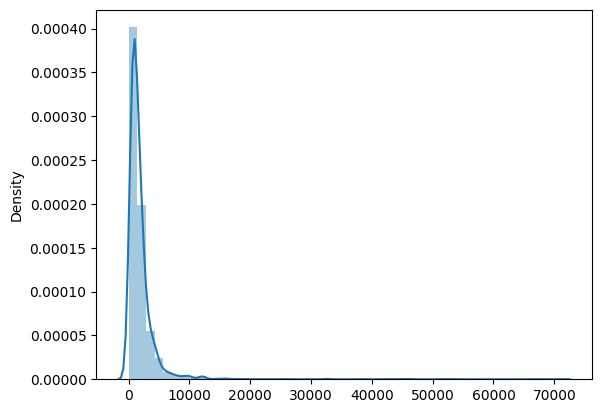

In [ ]:
doc_lengths = []

for script in scripts:

    # get rough token count distribution
    tokens = nltk.word_tokenize(script)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [ ]:
# the max token length
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.7242109722516415

In [ ]:
np.average(doc_lengths)

1878.2046176657489

Even though these token counts won't match up to the BPE tokenizer's, I'm confident that most bios will be fit under the 768 embedding size limit for the small GPT2 model.

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens.

In [ ]:
SPECIAL_TOKENS = [
    '[FOCUSED MEDITATION]',
    '[BODY-SCAN MEDITATION]',
    '[VISUALIZATION MEDITATION]',
    '[REFLECTION MEDITATION]',
    '[MOVEMENT MEDITATION]'
]

# # You can link tokens to special vocabulary when instantiating
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", unk_token="<unk>")
# # You should be sure '<unk>' is in the vocabulary when doing that.
# # Otherwise use tokenizer.add_special_tokens({'unk_token': '<unk>'}) instead)
# assert tokenizer.unk_token == "<unk>"

In [ ]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

# ADDED SPECIAL TOKENS
# tokenizer.add_tokens(SPECIAL_TOKENS)
new_tokens_added = tokenizer.add_special_tokens({'additional_special_tokens': SPECIAL_TOKENS})
                                                                # ^ SPECIAL_TOKENS is a list
print('new_tokens_added', new_tokens_added)
print('new tokens ', tokenizer.additional_special_tokens)
# ADDED new config to set
configuration = GPT2Config(vocab_size=len(tokenizer)).from_pretrained('gpt2')
print('len tokenizer', len(tokenizer))
# configuration.vocab_size = len(tokenizer)  # UNCOMMENT

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


new_tokens_added 5
new tokens  ['[FOCUSED MEDITATION]', '[BODY-SCAN MEDITATION]', '[VISUALIZATION MEDITATION]', '[REFLECTION MEDITATION]', '[MOVEMENT MEDITATION]']
len tokenizer 50264
['<|startoftext|>', '<|endoftext|>', '<|pad|>', '[FOCUSED MEDITATION]', '[BODY-SCAN MEDITATION]', '[VISUALIZATION MEDITATION]', '[REFLECTION MEDITATION]', '[MOVEMENT MEDITATION]']


In [ ]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [ ]:
batch_size = 2

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [ ]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each bio in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the bio is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens.

If the bio is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [ ]:
dataset = GPT2Dataset(scripts, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

4,248 training samples
  473 validation samples


In [ ]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [22]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
# model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50264. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


In [21]:
# Test the base model's performance
med_type = 'visualization'
prompt = f"""<|startoftext|> [{med_type.upper()} MEDITATION]
Welcome to this {med_type} meditation script where you will imagine yourself at a calm peaceful beach.""" # is designed for preparing you for sleep. Start by flexing and relaxing your"""

generator = pipeline('text-generation', model='gpt2')
generator(prompt, max_length=512, num_return_sequences=1)[0]['generated_text']

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'<|startoftext|> [VISUALIZATION MEDITATION]\nWelcome to this visualization meditation script where you will imagine yourself at a calm peaceful beach. It is not meant to be read as anything beyond your normal physiological state of consciousness. This isn\'t about yourself. I have suggested that there are some physical signs you should see to aid in the development of lucid dreaming.\n1-3\n1.1) A pleasant feeling during meditation. This is known as "high energy" relaxation.\n1.2) Feeling relaxing. This is when you feel all of the sensations that cause your conscious being to vibrate and relax. It can be the most exciting or most relaxing experience of your life. It is usually one of the most challenging experiences for the individual as most of this can happen after just a few few minutes. If you are at all familiar with the concept, you have probably experienced a lot after seeing this:\n1-3\n3-4\n1.3) Feeling relaxed. This is when the body feels no pressure or pain, rather rather lik

In [ ]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [ ]:
# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(  b_input_ids,
                          labels=b_labels,
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,
                                    top_k=50,
                                    max_length = 200,
                                    top_p=0.95,
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
#                            token_type_ids=None,
                             attention_mask = b_masks,
                            labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,124. Loss: 3.355654001235962.   Elapsed: 0:00:48.
0:  bipartisan relaxed relaxed relaxed relaxing relax relaxed relaxed relaxed relaxing relaxed relaxing relaxing relaxation relaxation relaxation relaxation relaxation relaxation relaxation relaxation relaxation relaxation relaxing relaxation relax relaxation relaxation relaxation relaxation relaxation relaxation relaxation relaxation relaxation relaxation relaxation relaxation relaxation relaxation relaxation relaxation relaxation relax relaxation relaxing relaxation relaxation relaxation relaxation relaxation relax relaxation relaxation relaxing relaxation relaxing relaxation, relaxing, relaxation, relaxation, relaxation, relaxation, relaxation, relaxation, relaxation, relaxation, relaxation, relaxation, relaxation, relaxation, relaxation, relaxation, relaxation, relaxation, relaxation, relaxation, relaxation, relaxation, relaxation, relaxation, relaxation, relaxation, relaxation, relaxation, relaxation, relaxatio

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,124. Loss: 2.8408069610595703.   Elapsed: 0:01:42.
0:  increasing on purpose. this is part of my way of practicing all things as it will help you to practice. this is what I offer to everyone through this practice. just listen. this exercise is simple, so if you feel any discomfort, this exercise can help. but if you feel any trouble right away and you know the situation, you should use your hands to gently. this is not a difficult exercise, it is just a relaxing, so relaxation is necessary. you may feel discomfort in any area of your body and it is helpful if it is not discomfortous. it's okay if it is not trouble, but it can help your feet feel the same and you can also get better. feel better now. if any discomfort has been caused to your toes and your neck this is because your toes are sore and soft, so I can help you. do it with care. the idea is to gently pull out of your socks and shoes. let each ankle or forefinger go, and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,124. Loss: 1.6322412490844727.   Elapsed: 0:02:37.
0: daystart by focusing on your body. let go of any sensations in your body or any feeling in your chest and let your mind wander as you continue to let go of those sensations. just move your attention from your body to your thoughts, feelings, feelings, thoughts and feelings of sensations in your body. let each and every one of those sensations settle in one space or time, expanding your awareness of each and every part of your body, allowing each and every part of your body to expand and expand. make a mental note of each part of your body. do not just see your body as a place you are standing or as a shape. move your awareness from your body to your thoughts, your thoughts, your feelings and feelings of sensations, and all of those sensations, if there is any, expand, expand out or expand to expand out, to expand out or expand. let each part of your body expand as your thoughts expand up through the body, as if 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,124. Loss: 2.73445987701416.   Elapsed: 0:03:32.
0:  Hangbelow in a space where you want the most comfortable and comfortable experience, and you need a comfortable bed. you need comfort in this position so you can go beyond bedtime with each sitting and close your eyes. you will find comfort in the mattress, mattress cushion, blankets or in the bed. you can take a deep breath in through your nose. your breath will soften as you exhale and will feel a deep breath out. you can place your fingertips on your mattress as if you were holding a chair or a chair chair height with you, taking a deep breath in from the inside through the outside out and back and continuing to make your way to sleep. this meditation will help you relax and even feel more comfortable. you might be able to lie down and relax as your eyes close, but there is always the possibility of a tightness in your body that will soon leave you completely limp. take another deep breath and you begin to sin

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,124. Loss: 2.52435302734375.   Elapsed: 0:04:26.
0:  foodsas you take this time to sit up straight, breathe out as you are comfortably seated, let this area of your body relax, letting your body relax. bring your attention down to one area, then move your attention down to the area that you are currently sitting comfortably on, just like that now. notice your posture in this area. it will be your best posture to take this time to breathe in and relax your lower body into this area. this area of your body, so now turn your attention now down to two areas: the chest. your back, your feet, your shoulders, your back. your forehead, your eyebrows, your brow, your eyebrows, let your gaze move up to the area of your body that you are lying comfortably comfortably on right now. relax your abdomen and allow your belly muscles to relax a little bit. take a slow, deep breath in to the space that you are now lying comfortably on right now, allowing your belly muscles to relax 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,124. Loss: 2.7487661838531494.   Elapsed: 0:05:20.
0:  trailwelcome to the guided meditation on the mindful body scan. it is an important part of the practice, but it is also important to practice it as closely as you can with the techniques of the mind. but today's question: what should I take? is there any magic or powerful thing that can help me reduce stress? and I would like to begin with a brief video on how to practice mindful body scan, to get to the core of what mindfulness means. the reason is because we use the following technique: we have to get to the heart of the whole body and to scan everything in a certain way. that means we must focus on the heart, which is one of the most prominent centers in the body and our sense of body. our heart, as we focus here, must be our focus. and now let's get started with what I've talked about before. how is the heart actually located at our heart? what can we sense here? what is it like to notice


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,124. Loss: 2.363539457321167.   Elapsed: 0:06:15.
0: intendso, so you've been to school once and taken a bath. it was at first nice of you, but then we decided you wouldn't get in a bath if you didn't have the bathroom. so we decided. you could see it in our eyes. there's no need to worry, no need to worry about it. all we can do is take a few breaths now and slowly breathe into this. breathe out every cell, every cell in your body. breathe into all the organs. breathe out every cell in your body now and see if you can feel it. breathing out every cell in your body now and inhale all the muscles in your body now and then take a few slow breaths, and slowly breathe into all the muscles in your body now and inhale that breath out and exhale that breath out. breathe in, breathe in, breathe out. breathe out, breathe out. breathe in and exhale. inhale, breathe out, breathe out. breathing in


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,124. Loss: 2.3960371017456055.   Elapsed: 0:07:10.
0:  surroundhey guys, welcome to the guided day meditation series. i invite you to make yourself comfortable with a seated position. take a deep breath in through your nose and exhale, filling the belly as much as possible with fresh air. your exhale expands your lungs and releases air as you let go. just notice your natural tendency to let go and release into the present moment. allow this breath to naturally flow into you and release back into the moment. this natural tendency has created a sensation of complete relaxation in your body. feel this relaxedness and letting go. your intention now is to bring this state of relaxation and allow this moment's relaxation to flow easily. as you listen to this recording you will notice this feeling of complete relaxation permeating your entire body. your entire body is safe. as you hear the sounds around you, sense these subtle movements of your body as well as your intent

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,124. Loss: 2.5715980529785156.   Elapsed: 0:08:04.
0:  reflexyou're ready to relax and enjoy your day at work. do you feel any tension in your shoulders or muscles around your face, eyes or even your eyebrows or any tightness? do you feel any pressure or tension, pressure or pressure? now that you have arrived at peace, welcome to the mindful movement. welcome to the mindful movement. today we will be focusing on meditation practice. after a moment of silence, give yourself permission to relax your muscles. we'll guide you through three simple body scan exercises. you simply need to make sure that your attention follows wherever your body allows it. if you are comfortable with lying on your back, you can lay down on your couch or chair. close your eyes. close your mouth and allow any distractions that may be present. begin the practice in the following way: start by relaxing your jaw and neck, moving your hands gently from the side to the other side of your mouth. 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,124. Loss: 2.3395423889160156.   Elapsed: 0:08:59.
0:  displaylet's start. I invite you now to make yourself comfortable. we have an opening in the door, your inner door, or any other place you are comfortable to be and allow yourself to let yourself fill up with relaxation. feel free to lie down in a position which, if available, will be entirely supported. close your eyes and begin to relax your body, relax your mind, allowing the energy of love to flow through you, starting with your breath. become aware of your breath with each exhale. breathe in deeply for the count of four. relax your belly. become aware of your belly and relax your body. begin to see how deeply your breath makes your body. imagine a beautiful white light that fills the entire length of your body and then passes through your body with each beat. feel it penetrate your body with ease. feel the healing energy of your belly. allow the belly to sink to the ground. now breathe in deeply, allowing 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,124. Loss: 2.580842971801758.   Elapsed: 0:09:53.
0:  pastorlet's start at the top, take a deep breath in, exhale, breathe out, take another deep breath out, and just keep this going. we are here today to honor the power of our higher self. we love your power. we love your life, it's your love. it's our soul's power. it's our life, it's your power, and we just can't control it. and so let's just take one more deep breath in and exhale a little bit more. one more breath in. do this three times. you may know that breathing and then, when you breathe out, you'll feel this tension and stress all over you. but let's think about that tension and focus here. there's this tension that's getting in our blood, the stress that we've been stressing out about, this tension that we've been stressing out about. and you may know that if we try to control these stress levels, it'll get in our


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,124. Loss: 3.2013723850250244.   Elapsed: 0:10:48.
0:  illicithello and welcome to this guided meditation. today we will take our journey through a deep breath in- and out, breathing in through the nose and exhaling through the mouth, using the air as a natural ebb and flow. as you breathe in, it makes the physical experience of breathing easier, it calms the tension in your body, relaxes your bones and joints, allowing the air to flow inwards and outwards as it spreads out through your muscles, with each breath and with each exhale. as you exhale, you feel the energy flowing through you back to a place where the air has been released. the breath comes in two or three different directions, depending on the duration of your next exhalation. in inhaling through the nose, you feel a cool sensation. you can feel this as a pleasant sensation, or you can feel it as a neutral sensation. you feel it as a slight warmth, or you can feel it as a warm light. this


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,124. Loss: 2.596318244934082.   Elapsed: 0:11:42.
0:  Liberationa quick morning mindfulness meditation, with a few gentle adjustments. hello, my name is jason stevenson and welcome to this session. my purpose today is to let you know that the mindful movement has been around a long time and this journey is just beginning, and all through our meditation, there's this practice of mindful awareness. mindfulness takes time for people. it's a journey of liberation. we have all the experience of the journey of enlightenment and it's amazing how many more people get to this point in time in life and that's why mindfulness and mindfulness meditation are so integral to our lives today. so, beginning today with the idea of grounding, it's going to be a short and sweet affirmation. i would like you to take a moment to get comfortable and sit comfortably. take a moment to just notice where your body feels and what the energy is going through your body right now. maybe a little

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,124. Loss: 1.7685186862945557.   Elapsed: 0:12:37.
0:  Namand welcome to another guided meditation that will help you feel more rested, more awake, if that's possible. if you haven't already watched the videos, do that now. but if you'd like to listen to this guided meditation before you listen to this video, I would advise you to do so. before we begin, I would like you to sit on a surface beneath your mattress or thick, thick pillow or pillows, whichever is easier for you. so take a breath in and out and then exhale as needed. sit on the surface on a low or firm surface that feels natural, with a few firm palms on the mattress or thick firm pads on the pillows. let your arms and hands rest against your thighs. take another deep breath in and out as needed. take a breath in and out again and breathe out gently as needed. if there's anything that feels heavy, feel free to gently breathe out a soft, full breath in and out. and now, as


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,124. Loss: 2.5259296894073486.   Elapsed: 0:13:32.
0: IONhey everyone, and welcome to the guided meditation for letting go and feeling calm, letting go of tension and grief. so find a comfortable position, sitting or lying down, with your feet crossed with your knees or wherever you're doing most relaxing activity of day, so your legs feel straight and your back relaxed. notice any areas that you can let go of, letting go and feel free to close your eyes or bring your awareness back to your breath or the natural rhythm of your breathing. breathe in deeply and breathe out slowly, allowing your exhale to come easily and effortlessly. take a few more deep, deep breaths, breathe in and exhale. your mind is wandering and your body is beginning to let go of the need for relaxation. take a few more deep breaths, take a few more deep breaths, let go and feel free to slow down, letting your head slowly roll back to a still rhythm. imagine you've just taken a few good, slow 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,124. Loss: 2.5752830505371094.   Elapsed: 0:14:26.
0:  glimpsehello and welcome to this guided meditation. please find a comfortable position with a nice long back straight back, legs crossed, hands folded, or in a comfortable sitting position, taking a deep inhale- exhale- as you find yourself drawn into the familiar sense of relaxation. just before we begin, let the inhale expand your body's capacity for giving relaxation to your heart. exhale in and out, letting the relaxation move up through your legs, your abdomen, down through your arms, your back, and exhale in, out, slowly. be patient with the release, be patient with the feeling of relaxation in your body, allowing your breath to be full and flow easily throughout your entire body. allow your thoughts to come and go, with just the intention to find stillness. what do you desire when you find yourself drawn into relaxation? what are the things that you desire or what feels good about your day today? it's ok

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,124. Loss: 2.831836223602295.   Elapsed: 0:15:21.
0:  Laureso, if you've had some meditation practice that has been out of your possession for a while, it's okay, just take it as you settle in. bring your attention up to the breath and breathe naturally in through the nose and out through the mouth, feeling the body soften, feel the body relax and release tension. allow your mind to wander off to the past or to the future. notice the stillness, the stillness, the stillness. allow all the sensations to be just as they are. feel the sensations moving along the body, coming and going and watching, in a straight line. no movement or stretching. the body is in sync with the chair or chair. the body is in sync with the chair or chair. feel the chair or chair relaxing the head and neck. notice the scalp and eyebrows, feel the muscles and relaxation, and then gently shift the awareness to the ears. continue to remain present with your listening for a while. bring the liste

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,124. Loss: 2.615548610687256.   Elapsed: 0:16:15.
0: ismwe have several videos and books on mindfulness, Buddhism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Taoism, Tao


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,124. Loss: 1.3531864881515503.   Elapsed: 0:17:10.
0: ounstart by settling into our meditation posture. if you're starting to fall asleep, you probably want to make sure you're lying down. simply let go of any tension in your body as you go into a deep, relaxed state of mind. if you can't sit, you can always sit down. you may find that lying down is more helpful and comforting. just allow your eyes to close on the bed. if you're sitting, you can gently tilt your head to the side and lie down. if your neck is tense, simply let go of it and shift your weight to the bed. now focus your attention to your feet, noticing where they're pointing and how they feel. allow them to be comfortable, but you don't want your feet to be tense or clenched. simply bring your awareness to your ankles, noting any sensations you might be able to feel. try not to tense the sensations. simply allow your feet to be soft. this relaxation practice is not to force, but


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,124. Loss: 2.4651412963867188.   Elapsed: 0:18:04.
0:  electionwelcome to your third bedtime story. I'm your host and I'm going to be your bff in this story, so let me ask you some questions: Who was your bff in college? who did you read? who didn't? who did you do all day? who was your bff at school? what is your bff like? what's your bff's? you know your bff's, you know the names of your bff, and then we get a little bit more about the bff. I was really curious to know what it is in life, what makes a man feel good? what makes a man feel good? well, what about what makes a man feel good? there are a lot of factors to how you feel good and people who do this exercise have a lot of different reasons for why they want to be attractive to others than they do because they love women. what does the motivation for getting attractive to them be? can


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,124. Loss: 2.9604132175445557.   Elapsed: 0:18:59.
0:  crazythis is a meditation focusing on the feelings of love and compassion for all those suffering from pain or suffering. this meditation is only available in the US. enjoy this session because it will help you relax, release and replace your old pain, suffering or any other pain, negative emotions, thoughts and feelings that can be carried away. i will first guide you on a short trip through the familiar state of your body. so first of all, please enjoy sitting. sit on your back, lie down on a mat or on a cushion or anywhere else that feels comfortable to you. if you like, you can make your back up so that you can sit at a comfortable, effortless position for a while. if you like, you can make your head up high, straight down, and just rest there for the duration of this session. and now close your eyes. begin to imagine you are standing in a field of pine needles. imagine this place, or you can imagine a thic

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,124. Loss: 2.925581455230713.   Elapsed: 0:00:53.
0:  benchhi, I'm Josh, and the yoga movement has a movement that's really good. the benefits are pretty obvious to understand. today it's my favorite, but the benefits include: this is what's really great for me, and for me it's also a nice little thing to implement into my life, and if you're new, this might be a little bit silly or it might be a little bit weird. these are the things that my life doesn't have to really control. it's only my hands and I have my two feet in contact with the ground or whatever the hell that might be called, but I can always just tap into my mind and practice my yoga and go with whatever I like, because if this is what I'm going to do, I can always tap into my mind and practice my yoga and go with whatever I like. my practice is just a little bit more than a bunch of stuff that I'm going to show you right now. it's a


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,124. Loss: 2.3433194160461426.   Elapsed: 0:01:47.
0:  incorporatedyou. to begin, i invite you to make yourself comfortable, choosing any position or position that feels comfortable for you. take a moment to make any adjustments to your posture or, if you choose, gently close your eyes. make any subtle adjustments to your body so you can move through this guided visualization and begin to shift into a more present awareness. allow your eyes to close if you need to allow the distractions of the outside to soften. allow your breath to return to its natural pattern, without making any changes. simply notice the natural rhythm of your breath as it flows in through your nose and out through your mouth. feel your body grounded and supported by the surface below you. listen to the layers of the sounds your breath makes on an internal or external call. can you hear my words without trying to change anything? you have the ability to change the sounds in your body. there is 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,124. Loss: 2.628070116043091.   Elapsed: 0:02:42.
0: Peterstart by just finding a comfortable seated position. and we are going to begin. let's take this practice of taking a seated posture. right now is really a very good idea. just take a moment to find a comfortable place, if that is comfortable for you. it's gonna be right, but I like to think right now we're gonna be sitting on our backs or some cushions, or maybe a blanket underneath us. the only time is when you're able to get up. so, if you're able to get up, maybe you can find a place where you're not lying down and you can be lying on your back, just sitting cross-legged, but it can be very comfortable to get into a relaxed position. so here we go. so let's take a few deep breaths, in and out, just feeling your body relax a little bit. as you're feeling your body soften a little bit, really softening your belly, letting go of any tension you


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,124. Loss: 2.549734354019165.   Elapsed: 0:03:36.
0: uringstart by getting comfortable. find a position that's comfortable and can be seated on your own, with your arms and legs uncrossed. close your eyes, allow your eyes to close down gently, bring your awareness to your breath. notice the natural rhythm of your breath. feel how it connects you to the surrounding scene. notice the natural rhythm of your breath when the air comes into your nostrils. invite a slowing down of your breath so it can be more easily released. notice your natural pause as your breath enters your body. begin to check in with the present moment. look inward for the path of your breath as your focus lingers. check in with the past and the present. check in with what has already occurred. take note of where your breath has left your body and where it's carrying on today, what's on your mind and what you're letting go of right now. consider the present tense. what's in your mind right now? che

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,124. Loss: 2.2946367263793945.   Elapsed: 0:04:31.
0:  reproductiveit's okay to be upset and analyze difficult things, not to judge yourself or others. but that's okay too. it's okay to be the observer of your problems, of your successes and failures. it's okay to simply be vulnerable. you're not alone, you're safe, you're loved. you can be free, you can be loved. you can be your own self. it's okay to be vulnerable, to be authentic, to be whole. there's no going back. there's no going back to the past. there's no going back to the future. there's no going back to the past. there is no going back to the present. there's no going back to the past. all we can do is remain the observer of our problems and, when the times are right, our actions, our words and words are the answers. just continue on your own, stay present, stay connected to your current experience. as you stay present, you'll


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,124. Loss: 1.60122811794281.   Elapsed: 0:05:25.
0:  zonebelow. to answer your question, and to get into your own answer, i asked that question: the question that has to do with it is: do you want to do things that are really kind to yourself and not get into a situation that you can access through your current job or your current job, through your spouse, through any other form of communication? so, as you're looking at it, just take the most seriously. do you want to be kind? are you feeling upset or sad or happy? all you need to know is: you are here. you are not having to face people that you know same way you do and those other people. i'm just like you are, right, and you've got a choice to make. so don't do that. you choose not to be a victim to those other people or do things that are really wrong. it's not wrong to be, because the choices to do that are a choice, and we've chosen


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,124. Loss: 2.677638292312622.   Elapsed: 0:06:20.
0:  commitslet's start. make yourself comfortable, taking some deep breaths as you begin this practice. your breath should naturally slow down as you settle in. allow your head to feel heavy and your shoulders to drop away from your ears. allow your chest to sink down and away from the top of your head. notice any tension and feel your face softening. notice any tension here, perhaps your jaw, your cheeks, the way your lips part, and allow this comfort to let go. close your eyes, if you haven't already done so, just soften your eyes as you bring your focus to the breath as you continue to inhale and exhale, and feel yourself releasing any tension from the brow muscles and your cheeks. breathe deeply, releasing any remaining tension in your face and your shoulders. feel your facial muscles and your cheeks relaxed. notice any tension or tightness or pain flowing from the muscles around your eyes. notice where you feel

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,124. Loss: 2.4755172729492188.   Elapsed: 0:07:14.
0:  ironywelcome and thank you for gif yourself these next few minutes to experience the magic of meditation. in a moment we will begin a relaxing journey into sleep, taking a moment for yourself to connect with the wisdom of your heart and to connect with your breath. before we begin, I invite you to make yourself comfortable. make any adjustments that may be necessary to your posture or your surroundings so that you can come into a place of effortless ease. to begin, find a position that you can be relaxed yet alert. you might prefer to lay down, but make any large shifts to your body so you can fully relax. approach this meditation with the intention to accept who you are and where you are heading, without judgement. give yourself permission rather than judgment. know that you are exactly where you need to be and, right now, simply focus on what is important to you right now. do you need to listen to everything 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,124. Loss: 2.7067601680755615.   Elapsed: 0:08:09.
0:  Sahthank you, welcome. this meditation is presented by my peace, of mindfulness. please enjoy this session in a secluded, peaceful location, giving yourself the relaxation you deserve. if you are new here, you can go to my guided meditation on adopting a tranquil environment. if you have not yet signed up for my free meditation, you can do that now, sign up for free and receive all of my free, 28-day program of 28 videos at absolutely no cost to you. to sign up, please do the simple scan over your body, coming into a comfortable position and placing your awareness on the top of your head. breathe deeply in and out through your nose, observing any vibration. notice your scalp and your forehead. feel your forehead. you may notice a lot of tension or knots. it may be there or it could be there. it's okay if that's not true. we don't need to worry about it. we just have to trust. we just have to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,124. Loss: 1.7721302509307861.   Elapsed: 0:09:04.
0:  Bryanthank you for joining me on this new episode, meditation for calm, mindfulness. meditation for calm, mindfulness. I know this is great, and meditation is great for calm. in the past it's hard for a meditator to do this. sometimes you have to do things because you're trying to control your thoughts. now, I'll give you a reminder for that, and I'll give you a reminder for that today: for today, let go of that tension and let go of anything that doesn't serve you. so breathe in slowly and breathe out slowly, so that you're sitting comfortably and, as you sit in this moment, notice your breathing and your breathing. so it's really a signal to your brain that this is the time for you to relax. and if you notice that something is happening for you, feel free to criticize yourself if you notice it. you don't have to be a perfect meditation person, but if you are, you can. thank you


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,124. Loss: 1.8287420272827148.   Elapsed: 0:09:58.
0:  spiritsstart by breathing in through your nose and out through your mouth. now take a long, slow breath in through your nose and out through your mouth. and as you exhale, let's really tune into our inner workings, connect with our thoughts and connect with the breath. let go of everything you're holding on to from the day, let go of all the noise and distractions and come into the present moment. bring your consciousness, your inner ecosystem, up from the clouds into the sky and now let that vibration, that lifeforce, that intuition come to you. feel that vibration, that light inside your body, your heart, your lungs, your heart space and now feel that energy moving up to your back, your stomach, your chest and your back. feel that energy in your back and your shoulders, back your neck, back your throat, your mouth, down behind your head, feel that energy traveling down your body to your ankles, your knees, yo

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,124. Loss: 2.373137950897217.   Elapsed: 0:10:52.
0:  seesstart by finding a position that is free from distractions and allow your eyes to close or you can lie down to take a moment to just settle into this moment and get yourself comfortable, close your eyes and just allow your eyes to close at all times you need to, allowing any sounds of this recording to be just as you can allow your ears to remain open and receptive at all times, allowing everything be the best you can, allowing you to be whatever you wish, allowing this is your time, this is your time to rest and relax, you're doing a great job, relaxing with every breath of your breath, relaxing, breathing in relaxing, relaxing, letting go, letting it all go, letting go, letting go, letting go, allowing your mind to be quiet, your subconscious mind to be quiet, letting go, allowing your mind to simply be and let go, letting go, allowing your body to relax and let go, letting go. as you can, let this sound j

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,124. Loss: 0.5925924181938171.   Elapsed: 0:11:47.
0:  hungryhello and welcome to this guided mindfulness meditation. find a comfortable seated position on a mat or in a quiet place, where you feel your body resting, your breath, and bring your awareness to your breath without making any changes. find a comfortable position, and close your eyes or soften your gaze. take a slow, deep breath in and let your breath out. notice how you feel, how it feels to have your breath in and out. bring your awareness to the top of your head, noticing the sensations of your forehead, eyebrows and eyes as they soften and smooth out. notice any sensations that have a softening to them. notice the cool air that gently touches your skin. feel the temperature of the air as it gently touches your face, mouth, temples and jaw. feel your shoulders and belly soften, letting go as you slowly breathe out, feeling your ribcage expand out as you breathe out. sense the sensations of your face w

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,124. Loss: 1.1462790966033936.   Elapsed: 0:12:42.
0:  PTthis is dedicated to all those spirits out there who believe life is meant to be magical. today I am going to bring you into alignment with the essence of your soul and you might ask yourself: why am i still so connected to my soul? I believe in all that I am and I believe in my abilities to create my own destiny in order to have that ultimate fulfillment. i believe in my intuition, my ability to heal my own body, my intuition to trust my intuition to let me know what's most important to me. why am I connected to the power that I live within? why am I connected to the power to love and compassion? why am i connected to the power that i have to shape my reality to my highest potential? why am i connected to the power to create an eternal life. why am I connected to the powerful power within me. how does my soul manifest when i am in alignment with the Essence of my soul? why am i aligned with the most beautifu

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,124. Loss: 1.4280749559402466.   Elapsed: 0:13:37.
0: ühi and welcome to another meditating session. it has been a long one and it has been a long, long time I thought it would be good to try and meditate together. so yesterday I got my go-on job and I went into a really long meditation and i really liked it and i really did it and it really blew my mind. so yesterday I decided to start meditating. you can start now. let me give you a few minutes. this is my first time. i love meditating with all my love and i really love this. today we will go into the session. and that's why we are going to be doing this meditation. for the next little bit of time we're going to be doing some breathing techniques. if you want, you can breathe in. when you breathe in, breathe in a nice long, slow, deep, slow, deep. breathe in through the nose. you can close your eyes. the rest of the time you can


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,124. Loss: 1.3228338956832886.   Elapsed: 0:14:31.
0: rucehi, it's Agnes and today we're gonna be doing a meditation for finding balance. so first off, i want you to remember that when you're looking to build a relationship, you may have this person or someone who you feel really good about, or someone that you think can be really good at that and then maybe there's something else that you want to change and take away from that. so just remember that this practice is about finding what you love, whatever that means for you, and it can help you feel really good about yourself as well. so find some space and close your eyes and just notice how you're feeling and what emotions you're feeling right now, because that's not what your meditation is about. it's about looking to make a positive change in your relationship. so when you do that, when you find your balance, notice how relaxed you feel and also feel like you could use some love.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,124. Loss: 2.399526834487915.   Elapsed: 0:15:26.
0:  derivativesstart by taking a deep breath in through your nose, then just gently exhale fully, letting it flow through your nose and out of your mouth with a sigh. to gently extend your diaphragm, simply pause for a second at the top and let the air travel down, just letting the air travel upward just as it is in your nose. you can reach your hands up to the shoulders and if you're leaning towards the chair, this allows you to soften the upper back and lower back. you might be able to even sense the full circumference of your stomach and feel it expand, expand and relax, moving through your upper back and in the low back. the chest and back rise and fall gently, as if you can breathe directly into your heart, allowing your belly to expand and relax. on the next breath in, you slowly let go and relax your hands. so, although your hands may feel tense, there is no need to tighten them, just let them go and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,124. Loss: 1.9152066707611084.   Elapsed: 0:16:20.
0: start by noticing where you are in your body right now, resting, sitting, being aware of where you are in this moment, being aware of how you feel right now, your breath, the path that you are taking, any sensations of temperature or pressure. feel this as your heartbeat and your abdomen expand as you breathe. feel this as an audible sound. notice your abdomen rising and falling as you focus on this moment right now, on how your body feels and what sensations are present within it. now, as you feel your abdomen rising and falling, allow your shoulders to drop back in alignment, your jaw to be slack, and you'll notice the tops of your shoulders subtly expand as you take another breath in and allow your shoulders to let go, releasing any tension you might be holding in. take your time with this process, allowing yourself to be fully present, feeling and appreciating all the moments in your day that have brought y

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,124. Loss: 2.670334815979004.   Elapsed: 0:17:15.
0:  rememberingmy name is jason stevenson and i invite you to make yourself comfortable. we will close the practice of mindful awareness and now shift focus of our attention to our breath and our physical body. we will first bring our attention to the full range of lungs in our body. we will direct our attention to each of the lungs, as they are always, with or without a condition. so we'll breathe in from the top of our head all the way down to the tips of the toes and breathe out from the bottom of the feet through the nose and out through the mouth through the nose and all the way through the mouth to the very tips of the toes and out through the mouth for the next few breaths. continue breathing this way for a few more cycles, breathing in and out through your nose and through your mouth for the next few breaths. we will repeat this on your own, if you find that is comfortable for you. now let's shift our focus 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,124. Loss: 2.261122226715088.   Elapsed: 0:18:09.
0:  Sourceslet's start. i invite you to set an intention for your day, an intention that you intend to live a happy and productive life for the next 21 days. intend to live in a way that aligns with your intentions for living the life that aligns with your values and desires. allow your intention to carry out if and when it is time, without judgment or expectations. intend to live in a way that is dignified and dignified, yet still unrelaxed, unrelaxed and reliable. intend to live in a way that supports the highest good, that allows you to be content in your natural and intuitive way of thinking. intend to live in a way that is aligned with your values, values and desires. be in a comfortable place where you can relax, where you will not be disturbed. close your eyes and take a deep breath in through your nose and out through your mouth, feeling the air as you breathe out. hold for a moment, releasing any tension or

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,124. Loss: 1.796697974205017.   Elapsed: 0:19:05.
0: emshi there, and welcome to meditating with the guidance of the Archangel Gabriel. this meditation is for you to practice welcoming the new year. you can choose to lay blame or blame the past on our circumstances, and it's good to feel sorry about ourselves and our circumstances, or you can forgive the past and be just grateful to your circumstances. it is such an easy process to bring to mind, but sometimes we can feel the effect of guilt and blame, and so we find ourselves overwhelmed with how much it can distract us. so, whatever you're going through right now, embrace it. I invite you to sit down if you like, or you could lay down whatever feels comfortable for you, and allow your eyes to close, but remain open to the sound of my voice as you continue to listen, begin to notice. maybe you become aware of a sound in your environment. that's completely normal. now you're going to begin to bring your attention t

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,124. Loss: 2.674138069152832.   Elapsed: 0:00:53.
0: tzlet's start our practice today by bringing our attention to our feet. since we are human, these two legs that our feet take up. as we breathe in, we're building our own internal energy source that can then be replenished through the exhalation of breath. as we let go of the outside world, we're making room for our incoming and outgoing energy to flow freely and naturally. as we continue to breathe, I'll invite you to imagine that you are breathing in relaxation. the more you do so, the deeper and deeper relaxation becomes. now imagine, if you can, that as your feet are relaxed, they're creating light, a light source, a light that can be tapped into by your roots. now allow your feet to be in the same level as your feet, but they're creating a whole new level of light, a light source that can be tapped in from within your feet. imagine this light is moving through each toe individually. allow each toe to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,124. Loss: 1.7354050874710083.   Elapsed: 0:01:47.
0: maticwhen you wake, you're still and you have just this one deep, restful, easy rhythm of life. you can go at a desk job or your day, you can create something on your own, whatever comes naturally to you. you don't have to be perfect. what's really important is just to wake up. you're okay. but if you don't wake up when you wake up, that's where the rest of the day can go: rest, refresh, relax. we're starting off this meditation with three parts, starting with the breath and then the body. so for your body part, you want to breathe in and breathe out. so let me give you this simple, simple breathing pattern, just your breathing pattern. it'll give you a sense of how you're feeling and you don't have to wake up. it'll just give you a sense of relaxation into your body and then in the next minute you'll have the awareness of it. it doesn


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,124. Loss: 2.471390724182129.   Elapsed: 0:02:42.
0:  syndlet's start. I invite you to make yourself comfortable. choose a position that you know you have the support of a loved one, perhaps close your eyes if you like, take a moment to make any adjustments to your posture or surroundings to settle in for this practice. choose a position in which you can be relaxed yet alert, where you feel safe to be and where you feel comfortable letting go of tension and your emotions. and now bring your attention to your breath, breathe naturally through your nose and notice the sensations arising. perhaps you notice the rise and fall of your chest. your belly rises and falls with each in-breath and each out breath. and now notice your thoughts. are they noisy or is there a noise to distract you? notice the thoughts as they arise and go by. notice what your body is experiencing now. notice your thoughts from afar as if you are an observer, and let them pass you by. know that th

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,124. Loss: 2.2878637313842773.   Elapsed: 0:03:37.
0:  gamin this video I'm going to be sharing with you a guided meditation that's called the 'Life force field' visualization, that's basically where you will be able to create and embody the energy of your life. it's going to be a powerful guided meditation that will lead you to manifest the life that you desire, that you deserve and that you love. it's going to be a powerful meditation that is specifically designed to help you tap into the energy that you are able to embody through the Force in your life. you do not need to believe that your life is complete yet. you do not need to believe that your life is fulfilling or that your life is destined to be perfect. you do not need to believe that your life is blessed with all the tools that you need to succeed or to attain success. you do not need to believe that your life is filled with all the luck and success that comes from what happens to your family or in the w

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,124. Loss: 2.1513917446136475.   Elapsed: 0:04:31.
0:  injurylet's start our journey into meditation by bringing our attention to our body as a whole, with acceptance and curiosity. since our bodies as a whole, they're being supported by the surface beneath us. take a moment now to observe where each part of your body is touching the surface beneath you, what sensations are here? no need to control your experience in any way. simply use the awareness of your body as your teacher of breath, without judgment or expectations. notice any subtle movements of your body, any tightness or coolness. whatever you are feeling is perfectly okay. just be with it. no judgment. be in the present moment. nothing has ever happened in the past. nothing will ever happen in the future. life always takes place in this present moment. our lives are a series of present moment experiences. what is there for you now? what does your body look like if you take a moment to scan through your b

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,124. Loss: 2.7411532402038574.   Elapsed: 0:05:27.
0: azalet's start. i invite you to find a posture that allows you to be alert and awake, yet still unrelaxed. choose a posture that you don't have to use much effort to maintain, either in a seated or lying down position. use this if you are experiencing a busy or stressful time in your life. allow your eyes to gently close if you need to and create an escape from the busyness around you. notice your environment using all of its senses to experience the sights, smells and sounds around you. take in the sights since the happenings around you using all of your senses. notice your breath now, without making any changes. you are exactly where you need to be. experience this right now. bring your attention to your breath, without making any changes. experience your breath just as it is. there is no need to manipulate it in any way. simply notice what is there. you are exactly where you need to be. begin to count the len

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,124. Loss: 1.5387684106826782.   Elapsed: 0:06:21.
0:  membranehi, this is jason stevenson and welcome to the infinity gateway. we are in the process of receiving an email from the infinity gateway, a special email address designed to connect you with all the information you need as we travel into outer space, a place where you can use your inner knowing and receive a communication message from the infinite creator. this email will allow you to connect with the intelligent life force and also to ask the wisdom and plan your ultimate plans. this email will also allow you to plan your exit for today's meditation. our intention for this meditation is to send you an email to reflect on the emotions and worries of today's day. once we get the emails, we are going to ask them to be sent back to us and then we will talk about what is the most important for us to do today. let's find some space. take a few moments here in the here and now to clear anything up. I would like

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,124. Loss: 2.580453872680664.   Elapsed: 0:07:15.
0: ijinglet's start. in this moment, we will remember our purpose: to honor our higher self. on this next level, we will always seek the truth. on this next level, we will never accept any darkness or fear. on this next level, we will never forget our own power, our own strength, our own love and our own joy. on this next level, we will be able to accept our own inner wisdom, an inner vision of our highest self that is always with us and always willing to meet us any time we need us. our higher self always takes care of us. even our higher self sees through the darkness, watches out for us and promises that he will see us in the light if we give him permission to be there. on that next level, we will never forget the beauty of what we are always able to feel. we always have the ability to express ourselves. on this level, we will never forget our own beauty. it is always our greatest


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,124. Loss: 0.938530683517456.   Elapsed: 0:08:10.
0:  casthello, my beautiful, wonderful yogi, welcome back to another video. today's meditation is for finding your peace within. the most important part of this meditation is finding our peace within, and so today we're going to take a deeper breath into the abdomen and then, as you exhale, we're going to start to feel this building, this feeling of peace within and through the body. so that may sound a little bit crazy, but simply finding the space within the abdomen allows us to experience this peace within. this morning's meditation is for you, so take a breath into the abdomen, breathing in through the nose, breathing out through the mouth through your mouth and breathing in again through the nose. make a belly expand. this means we breathe in, we breathe out through the mouth, it takes a deeper breath into the abdomen, it starts to feel like this building, this feeling of peace inside the abdomen that you're in

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,124. Loss: 1.374636173248291.   Elapsed: 0:09:05.
0:  purch- Hello, my darling friends. Welcome, Sister. Om Om. we need to talk about business practices and the difficulties that we face in the road. These are everyday. I have been working in the factory for years now and in the mid-hour today, I will share with you the daily challenges. With every experience I experience, I understand that it is an opportunity for me to understand the difficulties and solutions to them. They will become difficult. They will hinder my business and I am willing to work for them. They will bring with them more difficulties than the difficulties you might find in a factory. They are always at your door, even when you cannot get in touch with them. Sometimes they will stop working and come back, without your knowledge. They will affect your work, your relationship, your life and your relationships, all your relationships. Sometimes they are very unpleasant, But it is okay if we don't l

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,124. Loss: 0.9213040471076965.   Elapsed: 0:10:00.
0:  shouldersthis video, I'm going to be sharing with you the secrets of wealth with a gratitude mindset. gratitude is something that people talk about with, that's the way they use it. you will think about gratitude deeply when you have thoughts like this: oh, thank you, thank you, thank you. this is why I do this meditation with me and I believe gratitude is the key to understanding our wealth issues. the key is to understand what gratitude can actually do to us in our relationships. our relationships don't necessarily have that big responsibility and to have a big understanding of this. our relationships are based on how we respond to certain emotions, we always react to different things, and if you identify and start looking at the world and the emotions around us, it starts to begin to see that we have a very strong negative attitude towards gratitude. it starts to see that as, even if it's the emotion of grat

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,124. Loss: 2.205991744995117.   Elapsed: 0:10:54.
0:  builtthis five-minute meditation to settle stress in your body can reduce stress by setting off a signal to your body in your mind that it's time to relax. this five minute mindfulness meditation can also be used before bed to let go of tension and help you relax into sleep. hello and welcome. here we are an oasis where you can come to tap into your inner peace, positive mindset and the ability for self healing. and now I invite you to make yourself comfortable. find a position that you don't have to use a lot of effort to be in. take a moment and make sure your environment is all set for you. take a moment and make any adjustments you'd like to let go of. once you are settled, allow your eyes to close gently and bring your awareness to your breath. take a moment to notice the natural rhythm of your breath as it comes in and out through your body. by simply being mindful and intentional about your breath, we can

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,124. Loss: 2.7014541625976562.   Elapsed: 0:11:50.
0:  openlymeditation 1: exploring difficulty. this is a short meditation designed to help you tap into your own internal wisdom and the insight of your own mind. during this time, your thoughts may come and go in a variety of shapes and sizes, and sometimes they are thoughts of the past or projections of the future. this meditation is different from the three-dimensional or pure point-of-thoughts approach. instead of trying to make any decisions or set goals or desires, simply observe them with curiosity and compassion, allowing your mind to rest aside as you discover what's really occurring. now. once you find your resting place, bring your attention to the surface that holds you. notice any points of contact or points of tension. whatever you notice is perfectly natural. simply notice these points of contact without judgment to allow them to be what they are, without trying to assign words to what's there. you ma

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,124. Loss: 1.7334538698196411.   Elapsed: 0:12:44.
0:  haltedhello and welcome to this guided meditation to balance your chakras. allow us to begin our practice today by finding a comfortable seated position with your spine straight and your eyes closed. take a few deep breaths, in and out. take a few more breaths as you sink into a more relaxed, peaceful state. imagine, right now, that you are standing in a beautiful garden. as you look around you, you are completely safe. in this moment, imagine there are flowers in bloom, butterflies in flight. in this moment, imagine there are the flowers in bloom. in this moment, imagine there are the flowers. now imagine there are leaves being moved around by the breeze on a magnificent blue sky. in this moment you are completely safe. let your whole aura be open to the beauty of the day ahead. let your pure essence flow, flow through your being. imagine a beam of light and a beautiful emerald green light cascading over you. 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,124. Loss: 1.4732885360717773.   Elapsed: 0:13:39.
0:  Nikstart by taking a deep, slow breath in, hold for a moment and then slowly exhale. inhale and exhale. let's make our body as tall as it can, inhale and exhale. let's reach for the sky. inhale, holding for a moment. reach through the front of your body, exhale, rain down onto your fingertips and reach for the sky. inhale, holding for a moment. exhale, rain down onto your fingertips and reach for the sky. inhale, hold for a moment. exhale, rain down onto your fingertips and reach for the sky. inhale, hold for a moment. exhale, rain down onto your fingertips and reach for the sky. inhale, hold for a moment. exhale, rain down onto your fingertips and reach for the sky. inhale, hold for a moment. exhale, rain down onto your fingertips and reach for the sky. inhale, hold for a moment.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,124. Loss: 2.8913159370422363.   Elapsed: 0:14:33.
0:  tinthank you for choosing this meditation. this meditation is designed to help you overcome fear of failure. it is best used when people are experiencing high stress, anxiety and depression. the best place to start meditation is at home. choose a place where you won't be disturbed for the next 15 minutes or so, turn off all distractions and dedicate this time to improve your well-being and to improve your health. choose a place where you won't be disturbed and turn off all distractions and dedicate this time to improve your well-being and to improve your faith. feel free to place a cushion under your knees to help support yourself. if your eyes are closed, you can place a thin layer of cold light over your eyes to help open them. todays centering thought is: i am going to let go of everything that confronts me with my life. i know this feeling and it feels real, but if it is felt right now in your body, can you

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,124. Loss: 2.3902575969696045.   Elapsed: 0:15:28.
0:  clinicallet's start in a nice, comfortable seat. if you'd like to drop your shoulders down a little bit, that's fine. but once you're in, they go up. allow yourself to feel any tension in that lower back or the stomach area. let your chest and arms relax and just take any last bit of gentle, even breathing that way. it's really a calming and relaxing experience. so the next few minutes, I want you to really focus on the breath. just focus on it a little bit, starting in on the first inhale and then moving your attention to the exhale. it's going to be a bit different. so we don't want to give ourselves this task right away. but this focus is going to be different for each one. it's going to be very relaxing to continue slowing down your breath as best you can. so let's just focus on the exhale for the next minute. so if you keep breathing like this, you're


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,124. Loss: 1.4473586082458496.   Elapsed: 0:16:23.
0: lectionsyou and Jessica here with my very first meditation, and it's designed to help you reconnect with what you're feeling, what you want to feel, and that will help your life experience differently in a totally new way, and that will give you a way to be in a place that is different and that is giving you the opportunities and opportunities for change you want to make. now, when you connect with the feeling of it, can you go a little bit deeper into it, perhaps deeper into the feelings that are rising, feeling the feelings of your body, feeling it get more and more comfortable, the feelings that are growing more and more intense. can you feel your breathing getting more, more and more relaxed and it's almost as if it's coming in contact to the feeling of your emotions, the feeling of your being here. it's more and more in the physical space. it's a deep, deep connection to you, to what it is saying to you, th

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,124. Loss: 1.474142074584961.   Elapsed: 0:17:17.
0: elsif you find your mind wandering, you can always come back to the breath to calm your mind and your body, to remember what you are thinking and to reconnect your present moment self. that is why i'm going to repeat these five breaths: in through your nose and out through your mouth. so just allow my voice to be your guide, listening to what your body is saying to you, and as you breathe in, i invite you to imagine what's going on inside of your mind right now, the most powerful thought that you've ever had, and that is what that energy would be, the power to create the life of your dreams. and with each exhale, imagine imagining this life is taking on that life energy, the energy of abundance. with each exhale, imagine yourself being reminded that you are in control and you can choose to let go of the mantra and relax in a way that feels natural and natural to you. so for now, give yourself permission to just


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,124. Loss: 0.5973830819129944.   Elapsed: 0:18:12.
0: lablet's start. take a moment to elongate your spine, making it upright but not rigid or tense. if you feel strong, you can place your hands on your thighs or on the tops of your knees. either way, keep your hands on your thighs, on the knees or on your thighs, if you feel comfortable with that, place your palms on your thighs. if you're lying down, keep your back straight and your shoulders away from your ears. if you're in a chair, keep your back upright and your face down. take three deep breaths. breathe in for four seconds and exhale for five seconds. if thoughts arise, let them drift off, allow them to drift past and return your breath to its natural rhythm. continue this for a few more cycles on your own. allow your thoughts to drift into the background of your meditation. do not initiate your meditation. simply observe and notice where your mind is in the present moment and then gently let it go. your


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,124. Loss: 1.1924448013305664.   Elapsed: 0:19:07.
0:  triplethank you for joining me today. and today we're gonna do a guided meditation focusing on making time out. this is a meditation that you can use anytime in the future or in the past, anytime in the future. this is, I'm gonna call it a time-out meditation. it's not about how long your day's going to last, but more about that expectation that you're keeping in your head, that expectation that you're making progress that is coming to you, that expectation that you have, that expectation that you should have a little bit less. I know that some people who struggle with depression or feel anxious, they feel the need to just go off medication for the next 20 days and not even have the focus of the future. sometimes they feel like it's not about them, but it's a feeling of them, that feeling of how they need to have their life the way they want it to be, and this is very important. you can always say I

  Average 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,124. Loss: 2.0599238872528076.   Elapsed: 0:00:52.
0: 220welcome to this guided meditation to help you relax, calm yourself and reconnect with yourself as you go on a journey to find your ideal romantic partner. as you listen to this meditation each time you find yourself falling into a deep and satisfying relaxation, allow yourself to become more deeply absorbed by the sounds of this meditation. so, whenever you are ready, make yourself comfortable, allow your eyes to close, if they aren't already, for you can take a few deep breaths to let yourself carry away any stress or tension, making sure your breathing is just right for you and that your mind is just as still and peaceful as your breathing. begin to notice the sensations of your body on the furniture you are lying on. perhaps you can feel your breath, perhaps how it enters your nostrils and lungs, and maybe you notice how the wind pushes against your hair. whatever you are feeling is perfect. if thoughts or

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,124. Loss: 1.3748763799667358.   Elapsed: 0:01:48.
0:  Seei'd like to invite you to make yourself comfortable. you can choose to lie down on your back, your pillow, your bed or wherever else you feel comfortable. i'll take your time. make sure your spine is straight, your neck is relaxed and your shoulders are relaxed. allow your eyes to close if you wish and begin to turn off your sense of sight. bring your awareness to your breath. let it be natural and relaxed. in a moment i will guide you to take three deep, intentional breaths, in through your nose and out through your mouth at the top of your diaphragm. with each breath, breathe in relaxation, in calmness and in peace, and relax your jaw. release your tongue from your mouth. take a long, slow, deep breath in through your nose and now slowly let out a relaxing sigh through your mouth. allow this breath to last a little longer, pausing to finish. feel the release and expansion of each breath. notice how


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,124. Loss: 2.278993606567383.   Elapsed: 0:02:42.
0: @@hello and welcome to our meditation day 5. for today's meditation, let us Begin by finding a comfortable seated position and placing the hands on our knees. Take a deep breath in through your nose and sigh out through your mouth. Breathe in for 4.3 seconds and let go. Breathe out for 4.3. Let go Breathe in for 4.2., hold for 4.1.. Breathe out for 4.2.. Count the number of full, deep breaths in and out. Keep the breath going for 4.3.. and now let's count the number of hold and focus only on one. Allow yourself to keep counting your breaths. when you do this, you will feel more relaxed and allow for a natural calming effect to flow throughout your entire body. now, with the number of hold, allow yourself to bring the focus back to your breath: feeling the rise and fall of your chest, the slight pressure in your stomach, the softening of your


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,124. Loss: 1.280122995376587.   Elapsed: 0:03:37.
0:  hostlet's start with inviting your awareness to rest on your body. make any large adjustments to your posture or your surroundings so that you can come into a place of effortless ease. once you are settled, allow your eyes to close as you bring the lens of how you view the world from the outside to your insight experience. begin to let the sights, sounds and responsibilities of the outside world fade into the distance. let the sights, sounds and responsibilities of the outside world fade into the distance. choose to consciously relax, soften and let go of the need to keep everything as a distraction. take a deep neural in through your nose and sigh it out through your mouth like a sigh. feel your body grounded on the surface below you and, as you slowly scan your body, allow your awareness to move over each part of your body, noticing any Sensations or feelings that arise. simply observe the sensation, feel the 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,124. Loss: 1.370782732963562.   Elapsed: 0:04:31.
0: rolestart by breathing in and out through the nose and slowly filling your body as you slowly exhale and breathe in and out through your nose and slowly filling your body as you slow down the pace. let your tummy go. you may feel a rise and fall of your chest. you may feel a rise and fall of your chest. continue to breathing in and out through your nose and slowly breathing into your stomach. if you feel any tension in your stomach, let it go. continue breathing in and out through your nose, feeling that tension go. continue breathing in and out through your stomach and slowly breathing into your stomach. feel that tension go. now imagine that you're walking along a narrow path, the path of least resistance. you notice any cobblestones. there's a small path and as you walk it, you are able to see off onto tall grasses and flowers, and as you walk down the path, you reach into a corner of your own home and look ou

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,124. Loss: 1.270653486251831.   Elapsed: 0:05:26.
0: iachello and welcome to this guided astral projection meditation. on this journey, you will become one with the wisdom and guidance of the spirit world. as you listen, I will guide you to meet your highest dreams and help you prepare for a great journey. before we begin, I invite you to make yourself comfortable. prepare your environment to be completely free, as lights and decorations are likely not used. be sure to turn off all possible distractions and set this time aside for you. set any alarms now and turn off all lights. turn off all lights and create a space between your body and the outside world. your journey to astral projection begins in a comfortable place where you can relax. take a moment to fully focus on the journey you are about to embark on. as you breathe, notice the way you were breathing- slow, steady breaths, without any effort or strain. notice if you are holding any tension or worry. imagi

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,124. Loss: 1.4935909509658813.   Elapsed: 0:06:21.
0:  LDand these are my personal beliefs. I believe in myself 100% or 100% of the time. I don't believe that in a negative way or in a positive way at all. I want you to stop thinking about me and let me tell you about my beliefs. I was never gonna try to have a good faith faith faith session. I was going to want you to think of a specific person or thing or figure out what you were gonna be believing, then say I'm gonna leave it all behind you and you're gonna be successful in the process. you don't have to do anything but listen and do that, and I know if you don't do that, you'll end up feeling a little less successful and a lot less successful than when you were doing a bad faith session. you'll end up feeling a bit discouraged and a bit anxious and you're gonna end up feeling a little bit less than when you started that. you're going to say I'm gonna stay here


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,124. Loss: 2.025064468383789.   Elapsed: 0:07:15.
0:  Listenlet's start. we are gonna take 10 seconds to reset. go ahead and close your eyes. do that again in five, four, three, two, one. now take a deep breath in and hold it as long as you can, and then slowly breathe out as much as you can, feeling any tension leaving your body. again, breathe in through your nose, hold it for a couple more seconds, hold it for five, four, three, two, one and let it out. continue that cycle three more times and feel your breath slowing down. now just let it go at your own pace for now, listening to the sound of the music. you're gonna feel the heat, the sound of your breath. I want you to imagine taking a deep breath in, feeling cool air coming into your nose. just hold it and breathe out like that. that's in through your nose, hold it for ten seconds, nine, eight, seven, six, five, four


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,124. Loss: 2.5183777809143066.   Elapsed: 0:08:11.
0:  dywe are living a dream of a future that is so bright, so beautiful and beautiful- and yet it might be so hard to remain hopeful and hopeful in our days and weeks and months and years. and yet, right here and right now, our dreams of a future are the best that we can do. so, as we listen to the wonderful new love songs in this meditation, and with you as we continue this journey toward our future, begin to imagine that in this world, there is a place that exists beyond the physical world of the physical world- but there is an energy and a space of the soul and a place of the soul that says: if I do, I can create my future. I can create a future and I can bring it to this world. this is the power of the heart. the heart is pure love and it says to me: if I do this, I can live my life, I can learn and feel my way through my whole life.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,124. Loss: 1.5785499811172485.   Elapsed: 0:09:05.
0:  Domestica meditation for healing and closure. find a comfortable place, either sitting or lying down, where you are safe and your eyes are closed gently and gently. take a deep breath in and let it go. feel your whole body become more relaxed and calm. let go of your eyes and listen to the sound of my voice. feel a sense of calm and peace. feel your body become lighter and more comfortable. your mind is quieter, more at rest. you feel more at ease. begin to think of positive, wonderful things. how good it can feel to feel good and positive things, your life is so good. take a moment now to think of something you care for most deeply. this is a special gift. this gift will allow you to think of things you care for the most deeply, using this to recall, to think of new things you love. just like a movie, your imagination is full of pictures and ideas. now, with the image of this gift, think about


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,124. Loss: 1.2620437145233154.   Elapsed: 0:10:00.
0:  beneficiarieslet's start. find a comfortable position- sitting or lying down, keeping your back straight and your eyes closed. take a few breaths, feeling the air as it enters your nostrils, and just observe the way it moves with each exhale, just being aware of how it moves with each breath. take a moment to be aware of the way your chest and belly fill up, notice how your chest and abdomen rise and fall naturally with each breath. allow yourself to just let go of everything, let go of your body, your mind, your spirit, and let it go just gently. bring your awareness to the top of your head and just imagine the way your scalp and forehead soften with each deep breath you take. now imagine the way your facial muscles are relaxing, feeling your forehead soften with each breath you take. allow your eyes to just become heavier. just keep your eyes open. bring your awareness to your throat and let it go gently. bri

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,124. Loss: 1.318102240562439.   Elapsed: 0:10:54.
0:  Titlelet's start with the tip of the nose, so I like to rock it right ear to center, and then let's just settle down and kind of settle back down into your ear and we'll do four more repetitions of breath here, and you can just find that most important part of us. so for me, this is not my first time practicing with my dog. so I'm gonna give this a little bit of a summary: as I said, this was really just a very simple, quick exercise to just kind of settle back into the awareness of my voice. so today's practice is not all about trying to change my voice and it's not all about trying to tune into my mind. it's just more about just getting kind of comfortable, finding what feels good to you and relaxing into it. so, for example, if I had to do this again, what would feel good to me? would feel good in my ears? would feel good in my jaw?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,124. Loss: 2.2369420528411865.   Elapsed: 0:11:49.
0:  μstart by taking some nice deep breaths in through your nose and out through your mouth, inhaling deeply and fully and exhaling slowly. allow the breath to settle you and enjoy these nice natural, deep, rhythmic breaths. today we are going to do the a breathing technique. we're going to breathe through a series of abdominal breaths and this is going to be our way to getting the chest moving. so what we're going to do is we're going to breathe in through the nose and out through the mouth, really easy. so make sure you're comfortable and breathing normally, in through your nose, in through your mouth, into your lungs, out through your nose, and keep breathing at a pace that feels good. we're going to do a few cycles of breathing and this is going to be our most comfortable breathing pattern today, because it's going to be more of a relaxation pattern for us. make it more of a natural pattern. that's one of my fa

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,124. Loss: 2.2288920879364014.   Elapsed: 0:12:44.
0:  sellinghello and welcome. this meditation is designed to assist you in finding what it feels like to have a comfortable and quiet place within yourself. it can help with the start of your day, or you can simply feel a gentle rise and fall of your body as you allow yourself to settle into a sense of calm. as you progress through this meditation, your subconscious mind will hear everything you need to hear in your head, hear your body, your spirit and soothe and comfort you in every way, so that you may begin to drift off deeply into the relaxation and healing of sleep. there is no need to try to hear everything I am saying. you simply allow yourself to settle in to this moment. there is no need to seek any position or position that you find comfortable. simply simply allow your eyes to close, gently relaxing the muscles in your face and your forehead. soften your jaw. unclench your neck. feel yourself elongating

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,124. Loss: 1.0438809394836426.   Elapsed: 0:13:38.
0:  migrantwelcome to this guided meditation series. find yourself a quiet, comfortable place to listen to this meditation, close your eyes and take a few long, deep breaths. when you're ready, breathe in and breathe out. release all tensions in your body. feel your shoulders and neck melting away with each inhalation and exhalation. bring your awareness to your whole body. notice your whole face, your eyelids, your eyebrows, your eyes and now your face as a whole, your cheeks, your mouth and mouth. relax your jaw, your shoulders and allow your head to fall, naturally releasing any tension you may be feeling. breathe into your ears and allow them to let go. let go of any tensions in your ears. let the sounds around you be soft and relaxing. allow your body to release any tensions in your mind's eye, in your face. soften your jaw, allow your shoulders and your arms to let go. soften your face. feel any tension in yo

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,124. Loss: 1.7188901901245117.   Elapsed: 0:14:33.
0: ivelythank you for choosing this guided meditation for healing and relaxation. this guided meditation is intended to assist with healing and balance your mind, body and spirit bodies, especially in the morning and evening, when you will not be interrupted by outside noises, and also helps to allow you to let go of the burden of everyday life once you get up and settle into your day or evening. in a few moments, you will journey into a deep and tranquil sleep. before we begin, please turn off all possible distractions and set any time limits for yourself to allow your mind to fall asleep swiftly. to begin this journey, simply lie back against the covers and allow your body to sink into the position you just so comfortably find. close your eyes and allow yourself to settle into your bed for the night, settling into your hips, legs, arms, face and neck. feel the surface you're relying on against, feeling the softne

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,124. Loss: 0.8514211773872375.   Elapsed: 0:15:28.
0:  orderlet's start. please find a comfortable position, close your eyes. take a few long, slow, deep breaths, feeling all the tension and anxiety leaving your body. visualize everything you have to do to make your sleep come to a close. remember that you are safe and you have permission to let go to sleep. embrace the darkness of your eyelids and the darkness of your eyelids. you are a human being, just like everyone else, and this gives you the opportunity to heal, to let go and to allow the tension to just melt away, leaving your body feeling relaxed and at ease. take another deep breath and feel the breath gently inflowing your chest and drawing life into your body. every breath in brings in a certain quality of relaxation. as you take more and more breath, focus on relaxing each muscle on your face and the muscles around your eyes. you feel that relaxation flows out through your mouth, moving relaxation down 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,124. Loss: 1.980484962463379.   Elapsed: 0:16:22.
0:  VPNwelcome to this meditation for relaxation. check in with how you are feeling and then you can use this meditation as an energetic shift if you need. with this meditation, you may feel you need to adjust your body's boundaries for a little while to find your place of ease. this meditation will guide you to settle in as you begin your journey into a deep state of relaxation and tranquility. so, with some movement, find a comfortable upright position, allow your body to settle in and know you have complete permission to be here in this moment. know that you are safe. feel your eyes gently closed and focus your attention on your breath. take a long, slow, deep breath in through your nose and then slowly exhale fully. feel the tension leaving your body. bring your attention to your forehead and eyebrows. let the muscles around your eyes relax. feel your eyelids becoming very heavy. your eyelids become heavier. you

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,124. Loss: 2.559176206588745.   Elapsed: 0:17:17.
0:  explanationthis video, I'm gonna share with you some meditations that I find helpful and help you manifest or change your life that you want. so if you have any questions about a particular person and want to talk about this in a certain way, there are ways to manifest a specific meditation using a single affirmation or prayer. the key to this video is that you will be using these different techniques and techniques that you can actually access anytime by simply listening. so just find a place where you can sit down. it's perfectly fine to do so, you can lie down or sit up. just find a place where you are comfortably. you can have your back straight, but if you have to use a chair or a rolled up blanket you're also welcome to do so. so close your eyes, if that's comfortable, for now, just listen and listen to my voice. so now that you've listened to this whole meditation, let me just give you a little bit of a b

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,124. Loss: 1.3628579378128052.   Elapsed: 0:18:12.
0:  Bachwelcome to the magic book healing your mind and body. find a quiet place where you will not be disturbed. you can sit or lie down. take a deep breath in and let it go. fill your lungs and notice how powerful your breath is. hold it for a moment and then slowly release it. feel how relaxed you are. notice how strong your mind is and your body is positioned right now. take a deep breath in and now slowly release your breath. now imagine that you are breathing in an ocean, a calm and clean water. this water is a wonderful clean, clean and healing place for you to stay. it makes you feel very peaceful and relaxing. so just look where you are now and see how all of your body is relaxed. let your mind be aware of the perfect temperature that is perfect for you. turn your vision around and look at the beautiful world. see the mountains, the ocean, the clouds in the sky. just see the grass on the trees


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,124. Loss: 2.3347911834716797.   Elapsed: 0:19:07.
0:  folderhello and welcome to this guided meditation for reconnecting with your inner child. over the years, my family and friends have explored together and found what works for them. we have meditated together and gotten unstuck to answer your questions about what is important to understand and what is not important. this meditation will help you to relax a little deeper. so, in a moment, i will guide you on a path to reconnect with your inner child, as best you can. the intention here is to help you connect with your heart center, the part of your body that beats your body that receives guidance, faces, ears, dreams, experiences, and is responsible for breathing, thinking and forming new memories, all of which are associated with your inner child. these three parts of your bodywork together make up your body and your mind. now let us begin. make sure that your neck is straight and that you are in a comfortable 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,124. Loss: 1.8409515619277954.   Elapsed: 0:00:52.
0:  buildingstart by relaxing a little bit, inhaling slowly and exhaling slowly. so you are sitting on a hard chair and leaning back, facing the wall gently in your favor and, if you prefer, you can keep it on its own, but please enjoy that feeling. now take a deep breath in and, as you breathe out, visualize and imagine the breath you have just taken was coming all the way back out of your body, leaving no space whatsoever in your mind as you breathe in and breathe out and bring this breathing to a close, feeling your body and mind soften, your muscles relaxed, allowing your eyes to gently close, if they were closed, and just taking a few moments to just enjoy the relaxation you have just created, to enjoy this very present moment, the very life that you are about to create for yourself. so, just for the next few minutes, just allowing the breath to flow in and out gently and just allowing yourself to be open, let

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,124. Loss: 0.9899667501449585.   Elapsed: 0:01:48.
0:  Babylonlet's start again. my friends, my name is Jason Stevenson and welcome to the deserving and manifesting abundance guided meditation. in a few moments, we will begin to relax a little deeper as we absorb the innate talents of our minds and bring them into the present moment. right now, before we begin, let us take a moment to reflect on why we are coming to our meditation practice, what it is about, how it translates to our daily life. we are simply arriving here to observe, to be with the present moment, to be with the mind, to be with this present moment, to allow this moment to be exactly what it is, knowing that at anytime you need it, you can simply shift your focus to this moment by simply tuning into the space around your eyes, the room around you, and taking a few deep breaths as you open and close your eyes. I invite you to simply notice the surface beneath you and, if you haven't already done so,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,124. Loss: 1.2155324220657349.   Elapsed: 0:02:42.
0: perialstart by letting all your awareness go into your body and in your mind's eye, see yourself in your head. notice how you feel right now, where you're at, without judging or getting caught up in thought. simply watch, allow your awareness to be your experience. let the image of your body come to mind and what do you see? just watch. just bring your awareness to your face, your throat, your eyes and jaw. notice any sensation there. simply bring your awareness to the area of your face as you observe it, just noticing. now move your attention to your neck and throat, noticing if there's any tension there. just notice, just curiously, what's there and willing to let it soften. moving your attention up now to your shoulders, notice if there's any tension there. just let that be and notice. moving the awareness down now to your arms, notice your hands, noticing your upper arms and lower arms, moving down now to yo

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,124. Loss: 1.2438067197799683.   Elapsed: 0:03:37.
0:  rentsmeditation 8, the 3-minute breathing space. taking a breathing space, making a definite change in your posture so it embodies a sense of being awake, perhaps closing the eyes if that's possible, and beginning step one by seeing what's going on in your mind and body right now, with a sense of inquiry and curiosity. what is there for you in the present moment? what would it be like to shift your attention from the present moment to the future, looking to the feelings and experiences you're carrying with you as you breathe a little deeper? what's the weather pattern like inside, what thoughts are around, what feelings are here? how does it feel to be breathing right now? what's your experience right now? you may notice the thoughts as they appear in your mind and body, but you can just notice them as they are and then allow them to just come and go as they please, just as they always will. there's nothing to 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,124. Loss: 1.355699062347412.   Elapsed: 0:04:32.
0:  Reghello and welcome to this guided meditation. my name is Jason Stephenson and during this meditation we will be exploring the nature of unconditional love, of kindness and of a feeling unconditional worthiness. let's get comfortable and take a moment to elongate our spine, making it upright but not rigid or tense. close your eyes and rest your hands in an easy, effortless position with your palms open to the sky. with each inhale, feel yourself drawing deeply into the healing universal love and, as you exhale, release any tension, stress or pain. you take the first deep breath that you have taken all day so far, sending that breath into the stomach and expanding the chest and releasing that breath through the nostrils. and now breathe normally, allowing your body to sink a little deeper into the supportive surface beneath you, continuing this natural rhythm of breathing and allow yourself to tune in to the uni

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,124. Loss: 1.0285066366195679.   Elapsed: 0:05:26.
0: olaslet's start our meditation with a deep breath together and a big breath to the belly. one big breath, big breath to the belly. now inhale, reach the arms up overhead. exhale, palms down, knees down. inhale, reach the arms up overhead. exhale, palms up. inhale, reach the arms up overhead. exhale, palms down, knees down. inhale, reach the arms up overhead exhale, palms down, knees down. inhale, reach the arms up overhead exhale, palms down, knees down. inhale, reach the arms up overhead exhale, palms down, knees down. inhale, bring the palms together and then gently rotate the elbows forward, inhale, palm on the right hand side, reach the left hand side up and then come back to your side. exhale, palm on the left hand side, inhale, reach the left hand side up and then come back to your side. exh


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,124. Loss: 0.8248224854469299.   Elapsed: 0:06:21.
0:  responsesyou have chosen to listen to this guided meditation for healing and balance. perform this guided meditation in an area of peace, calmness and relaxation. choose your meditation position of comfort. you may walk, lie down, easy pose, sit in a chair or any lotus position- you may walk in any Lotus position, lie down in your back Lotus position and, when you feel comfortable, close your eyes, if it feels right to you, with your eyes open, or by squeezing them shut, closing them softly, if that feels comfortable, that's good, and as you listen to this meditation, you are entering a deeper understanding of yourself and the universe as it pours into your being. with your eyes closed, breathe deeply, feeling the clean, fresh air entering into your lungs, all the way down into your stomach and all the way down to your root chakra, your light, as you are filling this room with a sense of ancient wisdom, healing

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,124. Loss: 1.4546982049942017.   Elapsed: 0:07:15.
0:  attendanceyour meditation starts in five, four, three, two, one. welcome to this guided meditation visualization for relaxation and tranquility. to begin, fill your mind with profoundly relaxing images and positive affirmations. feel into the transformative power of this space in your body with the space you choose. when you are ready, close your eyes and begin to turn your attention inward, tuning in to your heart and the natural rhythm of your breath. pay attention to your breath as you breathe in. let it be your breath as it flows through you. feel the coolness of the inhale and the warmth of the exhale. feel the expansion in your belly, the rise and fall of your chest, the energy of your heart. expand your shoulders, your neck and your face. feel how each part of your body is fitting together perfectly like puzzle pieces. they are joining together perfectly like puzzle pieces. allow your breath to flow thro

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,124. Loss: 0.6829432249069214.   Elapsed: 0:08:10.
0:  rigidhi and welcome. here we are an oasis where you can come to tap into your inner peace, positive mindset and the ability for self healing. I want to share with you my personal story of being in the oasis, and now I want to share with you my story on finding my ideal life. let me tell you my story. I was an amazing, brilliant student and I did everything I set aside to learn. it is easy to say, but even I did it with an eye open. I was an amazing student. I did it with an eye open, but I was an amazing one. I began looking for love and success, and what I saw became my reality. soon I found it. I began looking for love and success, and what I saw became my reality. I am an amazing student. I did it with an eye open, but I was an amazing one. I began looking for love and success, and what I saw became my reality. I


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,124. Loss: 2.012516975402832.   Elapsed: 0:09:04.
0: grothe magic book meditation. guided meditation. it's time to relax a little deeper, and that's listening to the sound of my voice. in this guided meditation, I will guide you, with the help of my soothing and calming words, to let go of the habit of going to sleep while surrounded by other people in mind chatter. so now find a place where you can listen to the sound of my voice only when you are absolutely safe and that you can relax and fall asleep easily. make sure you are comfortable- seated or reclining- and turn off your mobile phones and, if you choose, sit or lie comfortably. close your eyes and take a few long, deep breaths, breathing in through your nose for the count of four, and breathing out through your mouth for the count of four. do this again: breathe in two, three, four, hold two, three, four, five and breathe out through your mouth for the count of six. and one more time:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,124. Loss: 1.889437198638916.   Elapsed: 0:09:59.
0:  Gremeditation 8, the 3-minute breathing space. taking a breathing space, making a definite change in your posture so it embodies a sense of being awake, perhaps closing the eyes if that's possible, and beginning step one by seeing what's going on in your mind and body right now. what's the weather pattern like inside, what thoughts are around, what feelings are here? any sensations in the body change? anything but opening to what's already here. then moving to step two: bringing the attention to the breath, narrowing the spotlight of attention on sensations of the breath in the abdomen, tuning into the changing physical sensations of the in-breath for its full duration, on the out-breath for its full duration and, if the mind wanders, simply acknowledging where it went and gently escorting it back to the breath. and now step three: expanding the focus of your awareness around the breath to take in the whole body

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,124. Loss: 0.43291953206062317.   Elapsed: 0:10:54.
0: urahello and welcome to the magic book guided meditation visualization for regaining balance. this guided meditation will help you to let go of the resistance while lowering your blood pressure naturally and effectively. over the next several minutes, you will gain a deeper understanding of the mind and body and will gain a more balanced connection with yourself. there is nothing you need to actively achieve here and everything in this moment is yours to use and by using this meditation, you will gain the grace and confidence necessary for regaining the positive energy you seek. we know that the mind and body are always working together, so let us gently introduce the following mantra: i allow myself to be silent. i allow myself to be silent. you may repeat this mantra a number of times before you experience deep relaxation, and it will continue to flow with you as you progress. if you find your mind wanders, c

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,124. Loss: 0.7953393459320068.   Elapsed: 0:11:49.
0:  2020today we're going to take a look at what meditation is called a miracle meditation. this is a visualization of the power and the gifts of a miracle. I've had many requests to meditate this, so I've created this meditation for you to visualize with me. if you have a magical friend, please share it with them. if not, please share this meditation with anyone you think can benefit from it in this format. for more information, please go through the normal meditation. the only thing that seems to be a problem right now is that it seems to get harder and harder for people. I have been working through this meditation and, as I have every meditation, I have people say to me: it's very hard to meditate, but this is the only reason I keep bringing it up. this is the miracle meditation. you need to have this power inside. so, in a moment, I want you to bring up this powerful, miracle energy, because it really is


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,124. Loss: 0.881601095199585.   Elapsed: 0:12:43.
0:  chargingwelcome. this is Sara Raymond, with the mindful movement. even though we are practicing together from afar, know that I am grateful to share this experience together. as I am making these recordings, I sense the energy of our listeners from around the world and I thank you. the love and light in me honors the love and light in you. today's practice is about exploring the lessons offered to us by mother nature when we are willing to listen and learn. the cycle of the seasons, year after year, has a lot to teach us. each season has meaning and can invite contemplation of the connections of nature to our own experiences. now I invite you to make yourself comfortable, sit or lie down in a way that allows you to find ease in a position where you feel safe to be supported by the surface below you. begin this practice in a position that allows you to be completely supported by the earth, with your hands on your

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,124. Loss: 0.5137385725975037.   Elapsed: 0:13:37.
0:  Sarwhen you practice gratitude, you can affect your health and your well-being. the good news is that you don't have to believe in a particular way to feel grateful. no matter what happens in life, it's okay. love and gratitude are already within you. thank you for practicing with me today. I hope you have a wonderful day.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,124. Loss: 1.0221108198165894.   Elapsed: 0:14:31.
0:  Jasstart by finding a comfortable position, either seated or lying down. allow your eyes to close gently and take a few deep breaths, inhaling through your nose and exhaling out of your mouth. do this again, breathing in fully and deeply through your nose and out of your mouth. one more time, big inhale and gentle exhale, allowing yourself to begin to relax. now just let your mind wander as you breathe, just observing what it feels like to breathe deep in meditation. the deeper you go, the easier it will be to follow your breath. so just keep going and just observe and notice your thoughts, gently, coming to the very front of your mind and then your awareness slowly broaden to the space around you. notice what space you are in. maybe there are sounds around. if you're not sure what sounds are around, just simply notice them and then begin to focus on your thoughts again. very good, now start to let your thought

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,124. Loss: 1.7664297819137573.   Elapsed: 0:15:25.
0:  permityou. hello. welcome to this guided meditation. but was thing on being present and practicing mindfulness. I want to thank you for taking the time to honor yourself with this meditation. I'm so grateful you have chosen me as your guide. by using your breath as an anchor, you can get grounded in the present moment at any time in your life. please find a comfortable place where you can relax, turn off any distractions and not be disturbed. now make yourself comfortable either in a seated or lying down position, close your eyes and begin to notice your breath. you have chosen to take the time to honor yourself in a positive way. by bringing mindfulness to the way that you live, you are strengthening the connection between your body and your mind. you have chosen to build a skill of mindfulness and living in the present without making any changes to your breath. notice how it flows in through the nose and fill

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,124. Loss: 1.9477602243423462.   Elapsed: 0:16:20.
0:  Administratorstart by taking a deep breath in through your nose and out through your mouth. make sure there's any distractions around you. I know it can be really distracting, you know, especially with this quiet time that we have together right now, especially as we prepare for this practice. so, sitting up nice and tall- just lots of space to breathe in and out through the nose, make sure there are no distractions and just focus on your breathing. make a big, steady breath in through the nose, filling up the belly and the chest, and let the breath out, fall the shoulders back. I know that is a little challenging, but just keep your attention, your awareness, gently coming back to the sensations and the breath. this is your time to relax. right now. this is the time to be calm and centered. we want to be centered, we want to be balanced. right now, take a deep breath in through your nose and out through your m

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,124. Loss: 1.0109690427780151.   Elapsed: 0:17:14.
0:  EVENTSstart by noticing how we're feeling. can you label it or don't label it, just notice, notice what it's like for you to just notice and then see what can you do about that. okay, let's just take a deep breath in and a nice soft exhale out and we're on the inside of our bellies and we're going to just move our fingers and we're going to relax our shoulders, our arms, our elbows and we're just moving our fingers and our toes and we'll scan our body. maybe you can notice a slight tingling sensation or it might be softness or it could be anything. we don't have to do anything special to notice any of it at all. so that's how we're moving. when you do that kind of exercise, just notice how you're feeling. can you feel your shoulders just moving down and just moving your body with our attention. now, when you're ready, bring your hands together in


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,124. Loss: 1.1577194929122925.   Elapsed: 0:18:10.
0:  Mentalwhen your mind is distracted, you may think that you're not paying attention to what's happening, which can make you feel less calm and clear-headed. so it may be time to let your mind wander off and come back to the present moment. this is another thing that you can do when you're feeling distracted, which is to acknowledge that you're distracted and then gently bring your attention back to the present. let's see what it's like to be distracted by thoughts during meditation. imagine that you're standing on a train track. as you're walking, you see an illuminated path and as you proceed, you start to collide with other people and things and gradually see people's faces lit up and you can see how far your mind can go. you can begin to feel quite calm and peaceful during this moment and realize that the first part of the path is for you, so make sure to take notice of that path in the middle so you don't ha

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,124. Loss: 1.0991300344467163.   Elapsed: 0:19:04.
0: idshello. thank you for joining me for your meditation practice today, which is designed to help you reduce stress and anxiety. this practice is part of the boho beautiful free meditation and yoga program to sign up for free and receive the entire two week program of 28 videos at absolutely no cost to you. go to boho, beautiful dot life, slash free yoga. thank you again for being here with me today. i'm sending you all my love and all my light. namaste you.

  Average training loss: 1.31
  Training epoch took: 0:19:18

Running Validation...
  Validation Loss: 1.78
  Validation took: 0:00:40

Training complete!
Total training took 1:39:49 (h:mm:ss)


Let's view the summary of the training process.

In [ ]:
# Display floats with two decimal places.
# pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,2.995020,2.337527,0:19:13,0:00:39
2,2.183123,2.125127,0:19:19,0:00:39
3,1.864607,1.970198,0:19:21,0:00:39
4,1.565152,1.816845,0:19:21,0:00:40
5,1.309907,1.775750,0:19:18,0:00:40


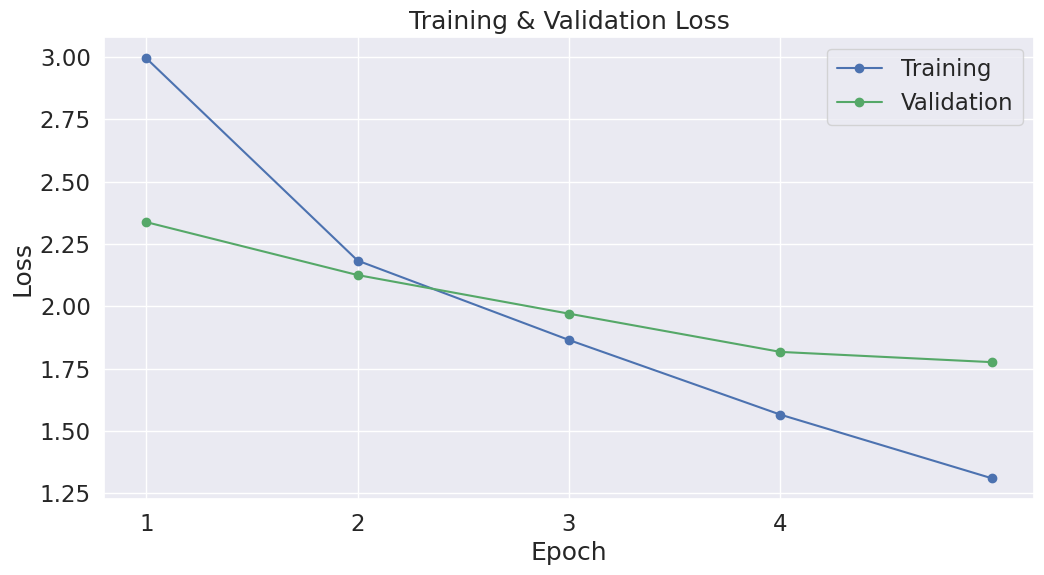

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# Fixed problems colab has sometimes that prevents hugging face login
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding  # function is necessary
print(locale.getpreferredencoding())

UTF-8


In [ ]:
# !huggingface-cli login
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
new_model = 'petern48/gpt2-meditation'

model.push_to_hub(new_model, max_shard_size='2GB')
tokenizer.push_to_hub(new_model)

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/petern48/gpt2-meditation/commit/64e0f96525734a0d5b1070f2195135c724aa37a2', commit_message='Upload tokenizer', commit_description='', oid='64e0f96525734a0d5b1070f2195135c724aa37a2', pr_url=None, pr_revision=None, pr_num=None)

# For Viewers:  
You may ignore the rest of the notebook. It was included in the original colab notebook from which I based the fintuning code on. See the other notebook `text_generation_model.ipynb` for testing the Text Generation Model that was just finetuned. It also contains example outputs for both our model and the base model

# Display Model Info

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50264, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-Tuned Model


In [ ]:
output_dir = './new_gpt2_meditation/'

In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


In [ ]:
# Added this to fix the next 3 commands
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding  # function is necessary
print(locale.getpreferredencoding())

UTF-8


In [ ]:
!ls -l --block-size=K ./new_gpt2_meditation/

In [ ]:
!ls -l --block-size=M ./new_gpt2_meditation/pytorch_model.bin

In [ ]:
model_dir = os.path.join(data_dir, 'new_gpt2_meditation')
model_dir

In [ ]:
!ls model_dir

In [ ]:
# # Copy the model files to a directory in your Google Drive.
!cp -r ./new_gpt2_meditation/ $data_dir

# Generate Text

#### Testing Parameters LLM
Try increasing temperature for more diversity in the generated text
Top-k represents how many of the probabilitic options to consider. Considers the k top options and picks one from random. Having 1 will just always pick most probabilistic option.  
Top-p is a value that restricts further that the top options cut off as soon as they sum to at least top-p value

In [5]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = 'petern48/gpt2-meditation'
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)  # , trust_remote_code=True

# # Load a trained model and vocabulary that you have fine-tuned
# model = GPT2LMHeadModel.from_pretrained(model_dir)
# tokenizer = GPT2Tokenizer.from_pretrained(model_dir)

device = torch.device("cpu")  # USING CPU FOR NOW
model.to(device)
print(f'{model_name} Loaded')

petern48/gpt2-meditation Loaded


In [10]:
model.eval()

med_type = 'visualization'

prompt = f"""<|startoftext|> [{med_type.upper()} MEDITATION]
Welcome to this {med_type} meditation script where you will imagine yourself at a calm peaceful beach.""" # is designed for preparing you for sleep. Start by flexing and relaxing your"""
# Welcome to this body scan meditation script is designed for preparing you for sleep. Start by flexing and relaxing your

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated,
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,
                                top_k=1000,
                                max_length = 512,
                                top_p=0.95,
                                num_return_sequences=1,
                                # early_stopping=True  # Added to try. Still ended mid sentence
                                )
response = tokenizer.decode(sample_outputs[0], skip_special_tokens=True)
print(response)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257,   220, 50261,   198, 14618,   284,   428, 32704, 16901,  4226,
           810,   345,   481,  5967,  3511,   379,   257,  9480, 12309, 10481,
            13]])
 
Welcome to this visualization meditation script where you will imagine yourself at a calm peaceful beach. This beach is magical and calming and you will Usually spend a couple of minutes getting lost in your thoughts and relaxing and then back to where you've just come from. if you are looking for more relaxing and positive meditations, you could also check out my other amazing affirmations video. Now that you have everything ready, go ahead and close your eyes and begin to imagine yourself walking towards the end of the beach and as you walk your hands towards the water, you notice that you notice that there's a backpack strapped to your shoulders. This is your nice and normal carry. wearing this backpack, you can let your kids pack up the things you need or just bring any stuff you need that you don't need an